In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay
)

import matplotlib.pyplot as plt
target_names = ['Not taking Contract', 'Takes Contract']




In [2]:
data = pd.read_csv('data/wallacecommunications.csv', delimiter=',')
# drop the month value with 'j' as it can be January, June, July
data = data[data['last_contact_this_campaign_month'] != 'j']
# drop ID as it is just identifier and Country
data = data.drop(columns= ['ID', 'country','last_contact_this_campaign_day','conn_tr','town', 
                           'married'])
# Replace the incorrect values to correct value
data['has_tv_package'] = data['has_tv_package'].replace({'n':'no'})
data['last_contact'] = data['last_contact'].replace({'cell':'cellular'})


In [3]:
binary_cols = ['arrears', 'housing', 'has_tv_package']
for cols in binary_cols:
    data[cols] = data[cols].map({'yes':1, 'no':0})

In [4]:
data['never_contacted'] = (data['days_since_last_contact_previous_campaign'] == -1).astype(int)
data['days_since_last_contact_previous_campaign'] = (
    data['days_since_last_contact_previous_campaign'].replace(-1, np.nan)
)

In [ ]:
categorical_features = ['job','education', 'last_contact', 
                         'last_contact_this_campaign_month', 'outcome_previous_campaign']
numerical_features = ['age', 'current_balance', 'this_campaign', 'days_since_last_contact_previous_campaign', 
                      'contacted_during_previous_campaign']

In [6]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='constant', fill_value=999999)),
    ("scaler", StandardScaler())
])

In [7]:
data_processor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocess, numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [8]:
X = data.drop(columns=['new_contract_this_campaign'])
y = data['new_contract_this_campaign'].map({'yes':1, 'no':0})

In [9]:
X_85, X_test, y_85, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_85, y_85, test_size=0.1765, random_state=42, stratify=y_85
)

In [10]:
lr_pl = Pipeline([
    ("preprocessor", data_processor),
    ("classifier", CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    loss_function='Logloss',
    random_state=36,
    eval_metric='Precision'
))
])

In [11]:
lr_pl.fit(X_train, y_train)

0:	learn: 0.7448929	total: 142ms	remaining: 1m 10s
1:	learn: 0.7526761	total: 150ms	remaining: 37.4s
2:	learn: 0.7447138	total: 157ms	remaining: 26.1s
3:	learn: 0.7537747	total: 165ms	remaining: 20.5s
4:	learn: 0.7558005	total: 172ms	remaining: 17s
5:	learn: 0.7482289	total: 180ms	remaining: 14.8s
6:	learn: 0.7526761	total: 186ms	remaining: 13.1s
7:	learn: 0.7506956	total: 193ms	remaining: 11.9s
8:	learn: 0.7561534	total: 201ms	remaining: 11s
9:	learn: 0.7506805	total: 208ms	remaining: 10.2s
10:	learn: 0.7531215	total: 216ms	remaining: 9.59s
11:	learn: 0.7550432	total: 222ms	remaining: 9.04s
12:	learn: 0.7534562	total: 230ms	remaining: 8.63s
13:	learn: 0.7550316	total: 237ms	remaining: 8.23s
14:	learn: 0.7564322	total: 247ms	remaining: 7.98s
15:	learn: 0.7518497	total: 254ms	remaining: 7.67s
16:	learn: 0.7525366	total: 261ms	remaining: 7.42s
17:	learn: 0.7467033	total: 268ms	remaining: 7.17s
18:	learn: 0.7489035	total: 275ms	remaining: 6.97s
19:	learn: 0.7516667	total: 282ms	remaining:

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_pred = lr_pl.predict(X_val)
y_proba = lr_pl.predict_proba(X_val)[:,1]


CatBoost —  Acc: 0.850 | AUC: 0.810


<Figure size 640x480 with 0 Axes>

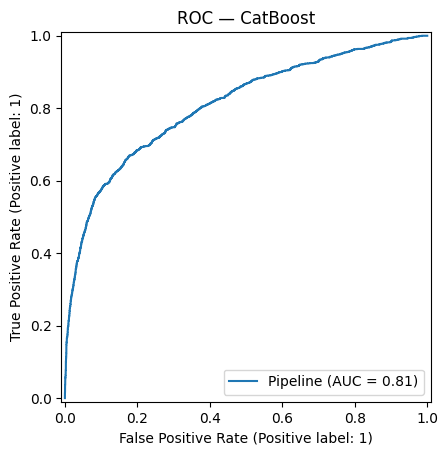

<Figure size 640x480 with 0 Axes>

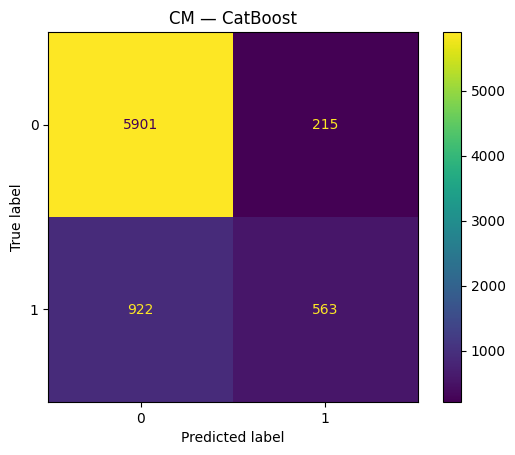


===== BASELINE MODEL ON VALIDATION FOR CATBOOST=====
Accuracy: 0.8504144191553743
Precision (YES): 0.7236503856041131
Recall (YES): 0.37912457912457914
F1-score: 0.4975695978789218
ROC AUC: 0.809678042689815
PR AUC: 0.6039942312236806

Confusion Matrix:
 [[5901  215]
 [ 922  563]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.86      0.96      0.91      6116
     Takes Contract       0.72      0.38      0.50      1485

           accuracy                           0.85      7601
          macro avg       0.79      0.67      0.70      7601
       weighted avg       0.84      0.85      0.83      7601



In [13]:
print(f"CatBoost —  Acc: {accuracy_score(y_val, y_pred):.3f} | AUC: {roc_auc_score(y_val, y_proba):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(lr_pl, X_val, y_val); plt.title("ROC — CatBoost"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred); plt.title("CM — CatBoost"); plt.show()

print("\n===== BASELINE MODEL ON VALIDATION FOR CATBOOST=====")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision (YES):", precision_score(y_val, y_pred, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba))
print("PR AUC:", average_precision_score(y_val, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=target_names))

In [14]:
param_grid = {
    "classifier__depth": [6, 8],
    "classifier__learning_rate": [0.03, 0.05],
    "classifier__iterations": [800, 1000,1200],
    "classifier__l2_leaf_reg": [3, 5, 7],
    "classifier__class_weights": [[3,10],[1, 2]]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=36)

In [15]:
grid_search = GridSearchCV(
    estimator=lr_pl,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [16]:

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
0:	learn: 0.7038598	total: 17.1ms	remaining: 20.5s
1:	learn: 0.6991844	total: 33.1ms	remaining: 19.8s
2:	learn: 0.6866311	total: 45.9ms	remaining: 18.3s
3:	learn: 0.7032581	total: 60.8ms	remaining: 18.2s
4:	learn: 0.7051038	total: 75.4ms	remaining: 18s
5:	learn: 0.7080501	total: 143ms	remaining: 28.5s
6:	learn: 0.7101017	total: 159ms	remaining: 27s
7:	learn: 0.7159973	total: 169ms	remaining: 25.1s
8:	learn: 0.7225528	total: 181ms	remaining: 23.9s
9:	learn: 0.7312675	total: 195ms	remaining: 23.2s
10:	learn: 0.7396839	total: 209ms	remaining: 22.5s
11:	learn: 0.7462431	total: 224ms	remaining: 22.2s
12:	learn: 0.7502113	total: 244ms	remaining: 22.3s
13:	learn: 0.7454220	total: 263ms	remaining: 22.3s
14:	learn: 0.7470905	total: 283ms	remaining: 22.4s
15:	learn: 0.7501953	total: 302ms	remaining: 22.3s
16:	learn: 0.7537669	total: 315ms	remaining: 21.9s
17:	learn: 0.7553441	total: 328ms	remaining: 21.5s
18:	learn: 0.7539954	total: 3

,estimator,Pipeline(step...4C6B1A4200>)])
,param_grid,"{'classifier__class_weights': [[3, 10], [1, 2]], 'classifier__depth': [6, 8], 'classifier__iterations': [800, 1000, ...], 'classifier__l2_leaf_reg': [3, 5, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [17]:
best_model = grid_search.best_estimator_

y_pred_ht = best_model.predict(X_val)
y_proba_ht = best_model.predict_proba(X_val)[:,1]

CatBoost  —  Acc: 0.852 | AUC: 0.873


<Figure size 640x480 with 0 Axes>

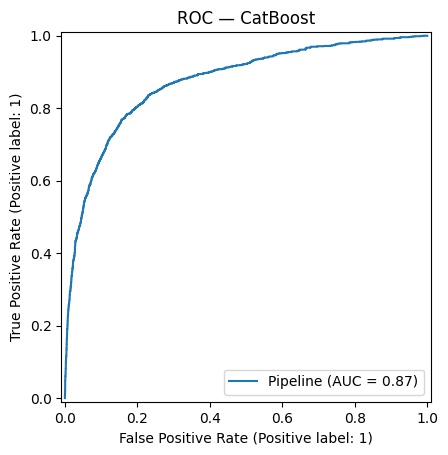

<Figure size 640x480 with 0 Axes>

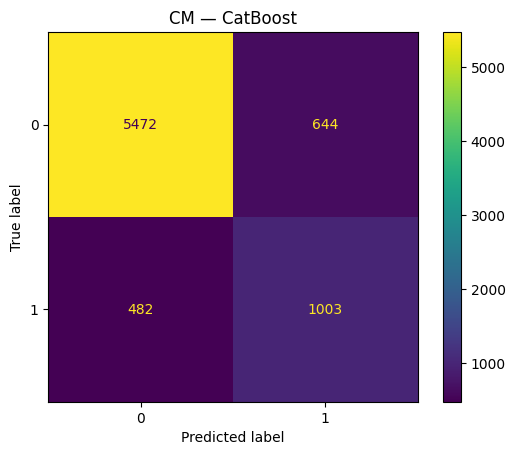


===== HYPERPARAMETERISED MODEL ON VALIDATION FOR CATBOOST=====
Accuracy: 0.8518615971582687
Precision (YES): 0.6089860352155434
Recall (YES): 0.6754208754208754
F1-score: 0.640485312899106
ROC AUC: 0.872860664636335
PR AUC: 0.6807313620250485

Confusion Matrix:
 [[5472  644]
 [ 482 1003]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.92      0.89      0.91      6116
     Takes Contract       0.61      0.68      0.64      1485

           accuracy                           0.85      7601
          macro avg       0.76      0.79      0.77      7601
       weighted avg       0.86      0.85      0.85      7601



In [18]:
print(f"CatBoost  —  Acc: {accuracy_score(y_val, y_pred_ht):.3f} | AUC: {roc_auc_score(y_val, y_proba_ht):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(best_model, X_val, y_val); plt.title("ROC — CatBoost"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred_ht); plt.title("CM — CatBoost"); plt.show()

print("\n===== HYPERPARAMETERISED MODEL ON VALIDATION FOR CATBOOST=====")
print("Accuracy:", accuracy_score(y_val, y_pred_ht))
print("Precision (YES):", precision_score(y_val, y_pred_ht, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred_ht, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred_ht, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba_ht))
print("PR AUC:", average_precision_score(y_val, y_proba_ht))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_ht))
print("\nClassification Report:\n", classification_report(y_val, y_pred_ht, target_names=target_names))

In [19]:
probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.01, 0.99, 300)

f1_scores = [f1_score(y_val, probs >= t) for t in thresholds]
best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print("Best threshold:", best_t)
print("Best F1:", best_f1)


Best threshold: 0.4721404682274247
Best F1: 0.6444919133353677


In [20]:
y_pred_th = (y_proba_ht >= best_t).astype(int)

CatBoost  —  Acc: 0.847 | AUC: 0.873


<Figure size 640x480 with 0 Axes>

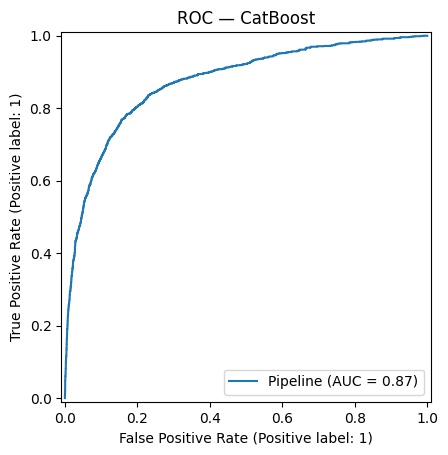

<Figure size 640x480 with 0 Axes>

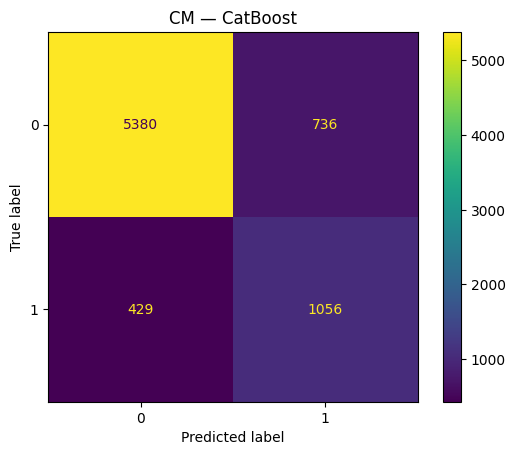


===== Threshold adjusted 0.47214 ON VALIDATION for Cat Boost=====
Accuracy: 0.846730693329825
Precision (YES): 0.5892857142857143
Recall (YES): 0.7111111111111111
F1-score: 0.6444919133353677
ROC AUC: 0.872860664636335
PR AUC: 0.6807313620250485

Confusion Matrix:
 [[5380  736]
 [ 429 1056]]

Classification Report:
                      precision    recall  f1-score   support

Not taking Contract       0.93      0.88      0.90      6116
     Takes Contract       0.59      0.71      0.64      1485

           accuracy                           0.85      7601
          macro avg       0.76      0.80      0.77      7601
       weighted avg       0.86      0.85      0.85      7601



In [21]:
print(f"CatBoost  —  Acc: {accuracy_score(y_val, y_pred_th):.3f} | AUC: {roc_auc_score(y_val, y_proba_ht):.3f}")
fig = plt.figure(); RocCurveDisplay.from_estimator(best_model, X_val, y_val); plt.title("ROC — CatBoost"); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_val, y_pred_th); plt.title("CM — CatBoost"); plt.show()

print("\n===== Threshold adjusted 0.47214 ON VALIDATION for Cat Boost=====")
print("Accuracy:", accuracy_score(y_val, y_pred_th))
print("Precision (YES):", precision_score(y_val, y_pred_th, pos_label=1))
print("Recall (YES):", recall_score(y_val, y_pred_th, pos_label=1))
print("F1-score:", f1_score(y_val, y_pred_th, pos_label=1))
print("ROC AUC:", roc_auc_score(y_val, y_proba_ht))
print("PR AUC:", average_precision_score(y_val, y_proba_ht))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred_th))
print("\nClassification Report:\n", classification_report(y_val, y_pred_th, target_names=target_names))

In [22]:
best_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value=999999,
                                                                   strategy='constant')),
                                                    ('scaler', StandardScaler())]),
                                    ['age', 'current_balance', 'this_campaign',
                                     'days_since_last_contact_previous_campaign',
                                     'contacted_during_previous_campaign']),
                                   ('cat', OneHotEncoder(drop='first'),
                                    ['job', 'education', 'last_contact',
                                     'never_contacted',
                                     'last_contact_this_campaign_month',
                             